<a href="https://colab.research.google.com/github/mauryask/Image-Forgery-Detection/blob/main/copy_move_forgery_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing the required libraries

import cv2  # opencv
import numpy as np  # numpy
from google.colab.patches import cv2_imshow

In [ ]:
# Initializing the variables

block_counter = 0
block_size = 8
temp = []

# Quantization table (matrix) fort DCT
q = np.array([[16,11,10,16,24,40,51,61],
              [12,12,14,19,26,58,60,55],
              [14,13,16,24,40,57,69,56],
              [14,17,22,29,51,87,80,62],
              [18,22,37,56,68,109,103,77],
              [24,35,55,64,81,104,113,92],
              [49,64,78,87,103,121,120,101],
              [72,92,95,98,112,100,103,99]])

In [ ]:
# Loading the source image

image = cv2.imread('forged1.png')

# converting image into grayscale (black and white)
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# converting the image matrix into numpy array
arr = np.array(gray_image)

# the prediction mask
prediction_mask = np.zeros((arr.shape[0], arr.shape[1]))

# calculating number column and rows 
col = arr.shape[1] - block_size
row = arr.shape[0] - block_size

# Creating an empty matrix to store individual DCTs
val = 16
dcts = np.empty((((col+1)*(row+1)), val+2))

DCT calculation, quantization and zigzag scanning

In [ ]:
print("Scanning and calculating DCT...")

for i in range(0, row):
    for j in range(0, col):
        
        # getting overlapping blocks of 8x8 from given image pixel matrix
        blocks = arr[i:i+block_size, j:j+block_size]
        
        # float conversion and scaling
        imf = np.float32(blocks) / 255.0

        # Calculating DCT for individual 8x8 blocks  
        dst = cv2.dct(imf)  

        # Convert back to the original form
        blocks = np.uint8(np.float32(dst) * 255.0)

        # Quantization (Dividing each element of DCT matrix with 
        # corresponding elements of the quantization table)
        out = np.zeros(shape=(8,8))
        for x in range(0,8):
          out[x] = np.divide(blocks[x], q[x])
          out = np.uint8(out)

        # Zigzag scanning
        solution = [[] for k in range(block_size + block_size - 1)]
        for k in range(block_size):
            for l in range(block_size):
                sum = k + l
                if (sum % 2 == 0):
                    # Add at beginning
                    solution[sum].insert(0, out[k][l])
                else:
                    # Add at end of the list
                    solution[sum].append(out[k][l])

        for item in range(0,(block_size*2-1)):
            temp += solution[item]
        
        # Converting the the coefficients into float
        temp = np.asarray(temp, dtype=np.float)

        # Discarding the rest of the coefficients as there 
        # contribution to the energy is very less
        temp = np.array(temp[:16])
        temp = np.append(temp, [i, j])  

        # Copying the each temp array to the dcts matrix
        np.copyto(dcts[block_counter], temp)

        block_counter += 1
        temp = []

print("Scanning and DCT calculation over...")

Scanning and calculating DCT...
Scanning and DCT calculation over...


Applying lexicograaphical sorting 

In [ ]:
print("Lexicographic sorting starting...")

# Removing rows containing only zeros in the DCT matrix 
dcts = dcts[~np.all(dcts == 0, axis=1)]

# Applying lexicographical ordering
dcts = dcts[np.lexsort(np.rot90(dcts))]

print("Lexicographic sorting over...")

Lexicographic sorting starting...
Lexicographic sorting over...


Applying euclidian opertaion to identify similiarity vectors

In [ ]:
print("Euclidean operations starting...")

sim_array = [] # similiarty array
tsimilarity = 5
tdistance = 20
for i in range(0, block_counter):
    if i <= block_counter-10:
        for j in range(i+1, i+10):
            pixelsim = np.linalg.norm(dcts[i][:16]-dcts[j][:16]) # calculating euclidian distance
            pointdis = np.linalg.norm(dcts[i][-2:]-dcts[j][-2:])
            if pixelsim <= tsimilarity and pointdis >= tdistance:
                sim_array.append([dcts[i][16], dcts[i][17], dcts[j][16], dcts[j][17],dcts[i][16]-dcts[j][16], dcts[i][17]-dcts[j][17]])
    else:
        for j in range(i+1, block_counter):
            pixelsim = np.linalg.norm(dcts[i][:16]-dcts[j][:16])
            pointdis = np.linalg.norm(dcts[i][-2:]-dcts[j][-2:])
            if pixelsim <= tsimilarity and pointdis >= tdistance:
                sim_array.append([dcts[i][16], dcts[i][17], dcts[j][16], dcts[j][17],dcts[i][16]-dcts[j][16], dcts[i][17]-dcts[j][17]])

print("Euclidean operations over...")

Euclidean operations starting...
Euclidean operations over...


Eliminating Dissimilar pixels

In [ ]:
print("Elimination starting...")

sim_array = np.array(sim_array)
delete_vec = []
vector_limit = 20
vector_counter = 0
for i in range(0, sim_array.shape[0]):
    for j in range(1, sim_array.shape[0]):
        if sim_array[i][4] == sim_array[j][4] and sim_array[i][5] == sim_array[j][5]:
            vector_counter += 1
    if vector_counter < vector_limit:
        delete_vec.append(sim_array[i])
    vector_counter = 0

delete_vec = np.array(delete_vec)
delete_vec = delete_vec[~np.all(delete_vec == 0, axis=1)]
delete_vec = delete_vec[np.lexsort(np.rot90(delete_vec))]

for item in delete_vec:
    indexes = np.where(sim_array == item)
    unique, counts = np.unique(indexes[0], return_counts=True)
    for i in range(0, unique.shape[0]):
        if counts[i] == 6:
            sim_array = np.delete(sim_array,unique[i],axis=0)

print("Elimination over...")

In [ ]:

print("Painting starting...")

for i in range(0, sim_array.shape[0]):
    index1 = int(sim_array[i][0])
    index2 = int(sim_array[i][1])
    index3 = int(sim_array[i][2])
    index4 = int(sim_array[i][3])
    for j in range(0,7):
        for k in range(0,7):
            prediction_mask[index1+j][index2+k] = 255
            prediction_mask[index3+j][index4+k] = 255

print("Painting over!")

Painting starting...
Painting over!


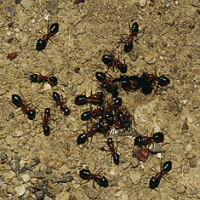

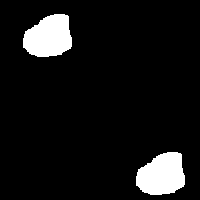

In [ ]:
cv2_imshow(image)
cv2_imshow(prediction_mask)
cv2.waitKey(0)
cv2.destroyAllWindows()